# Bird's eye page view classification
The hypothesis here: there are enough of visual cues for the human eye to hint the page orientation on the low-resolution view and the outlines if present. We cannot read the text from the image, but we know the page orientation, and if some text is present, if a table is present, if some inputs are present. Let's estimate how well we could do that with a neural network.

For this experiment we generate a noisy dataset of images which we first straighten-up, means the outcome may not be perfectly aligned (20% will have 1º+ residual skew), then, using this data, we train `orientation` [`0`,`90`,`180`,`270`] detector model. The model will take a low-resolution view as an input. For the page `content` classification as a bare minimum we want to be able to determine presence of the data inputs like [`form`,`no-form`]. 

* [Orientation detection baseline](#orient)
* [Content classification baseline](#form)
* [Generate synthetic data](#data)
    * [Define labels](#labels)
    * [Create Dataset & Dataloader](#loaders)
* [Build model](#model)
    * Define visual encoder
    * Define classification heads
* [Define training utilities](#util)
* [Run training](#train)
* [Run evaluation](#eval)

In [1]:
import os
import re
import cv2
import torch
import pandas as pd
import numpy as np
import pytesseract as pts
import matplotlib as mpl

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from IPython.display import display, clear_output
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from torch import nn, Tensor
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, AdamW
from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix, Accuracy
from torchsummary import summary
from fitz import fitz
#from tqdm import tqdm
from time import time

In [2]:
# local lib
from scripts.baselines import *
from scripts.backbone import Encoder, CNNEncoder, TransformerEncoder, MeanReduce

In [3]:
#torch._dynamo.config.verbose = True
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('GPU' if device == 'cuda' else 'no GPU')

GPU


In [4]:
# images with semantic segmentation masks available
images = [str(x).replace('/masks/','/images/') for x in Path(f'{ROOT}/data/masks').glob('*.png')]
len(images)

8768

In [5]:
VIEW_SIZE = 128
LATENT_DIM = 512

<a name="data"></a>

### Generate synthetic data

In [6]:
save_path = './data/layout-baseline'

In [7]:
samples = images

num_variations = 5
#start = time()
#generate_data(samples, VIEW_SIZE, save_path, num_variations)
#print(f'average execution time: {(time() - start)/len(images):.2f}')

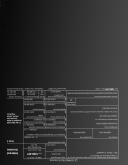

In [8]:
# see sample
Image.open(np.random.choice([str(x) for x in Path(f'./data/layout-baseline').glob('*.png')]))

In [9]:
validation_samples = list(np.random.choice(samples, int(len(samples) * 0.1), replace=False))
training_samples = list(set(samples).difference(set(validation_samples)))
print(f'training: {len(training_samples)}  validation: {len(validation_samples)}')

training: 7892  validation: 876


<a name="labels"></a>

#### Explore labels

In [10]:
labels = pd.read_csv(f'{save_path}/labels.csv.gz')
print(f'Generated samples: {len(labels)}')
labels.groupby('orientation').size()

Generated samples: 43761


orientation
0      11033
90     10809
180    10913
270    11006
dtype: int64

In [11]:
def set_labels(validation_samples: list) -> pd.DataFrame:
    """
    final version to use for training
    """
    labels = pd.read_csv(f'{save_path}/labels.csv.gz')
    labels['test'] = 0
    labels.loc[labels['source'].isin([x.split('/').pop()[:-4] for x in validation_samples]),'test'] = 1
    labels['type'] = (labels['inputs'] > 4).astype(int)
    return labels.loc[:,['orientation','type','path','test']]

labels = set_labels(validation_samples)
labels.groupby('test').size()

test
0    39390
1     4371
dtype: int64

<a name="loaders"></a>
<h4>Dataset and dataloader</h4>

    #loaders = get_loaders(VIEW_SIZE, labels, lambda x:x['orientation']//90, 8)
    loaders = get_loaders(VIEW_SIZE, labels, lambda x:x['type'], 8)
    for X, Y in loaders[0]:
        print('Batch:')
        print(X.shape)
        print(Y[0].shape)
        for i in range(len(X)):
            image = X[i,:].squeeze()
            plt.imshow(image, 'gray')
            plt.title(Y[i].item())
            plt.axis('off')
            plt.show()
        break

<a name="model"></a>
<h3>Model</h3>

In [12]:
class LayoutBaseline(nn.Sequential):
    def __init__(self, encoder, head):
        super(LayoutBaseline, self).__init__(encoder, head)


#### Define visual features encoder

    MODEL='RN18'
    LATENT_DIM = models.resnet.ResNet(models.resnet.BasicBlock, [2, 2, 2, 2]).fc.in_features
    print(LATENT_DIM) # embedding size

    class GrayResNetEncoder(models.resnet.ResNet):
        # https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
        def __init__(self, block, layers):
            self.inplanes = 64
            super(GrayResNetEncoder, self).__init__(block, layers)
            # the first layer grayscale adaptation
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.fc = nn.Identity()

    # ResNet18        
    encoder = GrayResNetEncoder(models.resnet.BasicBlock, [2, 2, 2, 2])

In [13]:
    backbone = CNNEncoder(out_channels=64, depth=4, residual=False)
    backbone.load_state_dict(torch.load('./models/visual-encoder-CNN-64-4.pt'))
    encoder = Encoder(backbone, nn.AdaptiveAvgPool2d((1, 1)), frozen=False)

    backbone = TransformerEncoder(VIEW_SIZE, 4, LATENT_DIM, 4)
    backbone.load_state_dict(torch.load('./models/visual-encoder-ViT-4-4.pt'))
    encoder = Encoder(backbone, MeanReduce(), frozen=False)

#### Define classification head

In [14]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, num_classes, activation=None):
        layers = [nn.LayerNorm(emb_size),
                  nn.ReLU(),
                  nn.Linear(emb_size, num_classes)]
        if activation:
            layers.append(activation)
        super(ClassificationHead, self).__init__(*layers)


In [15]:
orientation_detector = ClassificationHead(LATENT_DIM, 4, nn.Softmax(dim=1))
model = LayoutBaseline(encoder, orientation_detector)
inputs = torch.randn((16, 1, VIEW_SIZE, VIEW_SIZE))
model(inputs).shape

torch.Size([16, 4])

In [16]:
form_detector = ClassificationHead(LATENT_DIM, 1, nn.Sigmoid())
model = LayoutBaseline(encoder, form_detector)
inputs = torch.randn((16, 1, VIEW_SIZE, VIEW_SIZE))
model(inputs).shape

torch.Size([16, 1])

<a name="train"></a>

### Run training
#### 1. Define models

In [22]:
orientation_detector = ClassificationHead(LATENT_DIM, 4, nn.Softmax(dim=1))
orientation_detector = LayoutBaseline(encoder, orientation_detector).to(device)
#orientation_detector = torch.compile(orientation_detector)

form_detector = ClassificationHead(LATENT_DIM, 1, activation=nn.Sigmoid())
form_detector = LayoutBaseline(encoder, form_detector).to(device)
#form_detector = torch.compile(form_detector)

#### 2. Define optimization

In [23]:
# define new optimization
orientation_loss = nn.CrossEntropyLoss().to(device)
orientation_optimizer = AdamW(orientation_detector.parameters(), lr=1e-5)
#orientation_optimizer = SGD(orientation_detector.parameters(), lr=1e-6, momentum=0.9)

# calculate class weight for unbalanced representation
weight = 1 - len(labels[labels['type']==1])/len(labels)
print(f'positive class weight: {weight}')
form_loss = nn.BCELoss(weight=torch.tensor(weight, dtype=torch.float32)).to(device)
form_optimizer = AdamW(form_detector.parameters(), lr=9e-6)
#form_optimizer = SGD(form_detector.parameters(), lr=9e-7, momentum=0.9)

positive class weight: 0.23436393135440237


#### 3. Define evaluation metrics

In [24]:
orientation_metrics = {
    'confmat': ConfusionMatrix(task='multiclass', num_classes=4).to(device),
    'precision': Precision(task='multiclass', average='macro', num_classes=4).to(device),
    'recall': Recall(task='multiclass', average='macro', num_classes=4).to(device),
    'accuracy': Accuracy(task='multiclass', num_classes=4).to(device) }

form_metrics = {
    'confmat': ConfusionMatrix(task='binary').to(device),
    'precision': Precision(task='binary').to(device),
    'recall': Recall(task='binary').to(device),
    'accuracy': Accuracy(task='binary').to(device) }


#### 4. Train both models for a few epochs

In [25]:
batch_size = 128
# generate new data:
num_data_updates = 1
# epochs with the same data
num_epochs = num_variations * 2

In [ ]:
# initialize tracking
loss_history = {'orientation-detector':{'train':[],'validation':[]},
                'form-detector':{'train':[],'validation':[]}}
validation_history = {'orientation-detector':{m:[] for m in orientation_metrics},
                      'form-detector':{m:[] for m in form_metrics}}
# run training
for i in range(num_data_updates):
    # use generated data
    for e in range(i * num_epochs, (i + 1) * num_epochs): # run training epoch for both models
        labels = set_labels(validation_samples)
        res1, th, vh = run_range('orientation-detector', orientation_detector,
                                 labels, lambda x:x['orientation']//90,
                                 orientation_metrics, orientation_loss, orientation_optimizer,
                                 False, batch_size, range(e, e + 1))

        loss_history['orientation-detector']['train'] += th['train']
        loss_history['orientation-detector']['validation'] += th['validation']
        for metric, values in vh.items():
            validation_history['orientation-detector'][metric] += values

        # filter labels
        labels = labels[labels['type'] != -1]
        # calculate class weight
        weight = 1 - len(labels[labels['type']==1])/len(labels)
        res2, th, vh = run_range('form-detector', form_detector,
                                 labels, lambda x:x['type'],
                                 form_metrics, form_loss, form_optimizer,
                                 True, batch_size, range(e, e + 1))

        loss_history['form-detector']['train'] += th['train']
        loss_history['form-detector']['validation'] += th['validation']
        for metric, values in vh.items():
            validation_history['form-detector'][metric] += values

    # generate new data variation
    if i < num_data_updates - 1:
        generate_data(samples, VIEW_SIZE, save_path, num_variations)


#### 5. Show evaluation results

Final test confusion matrix:


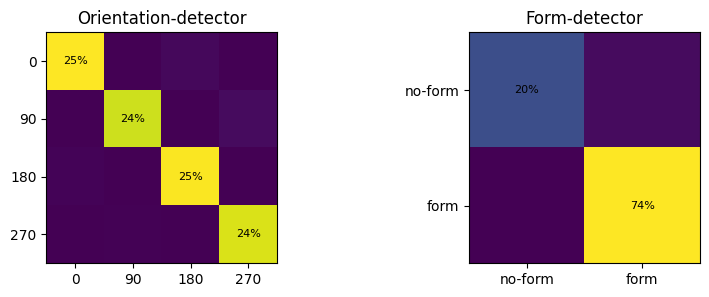

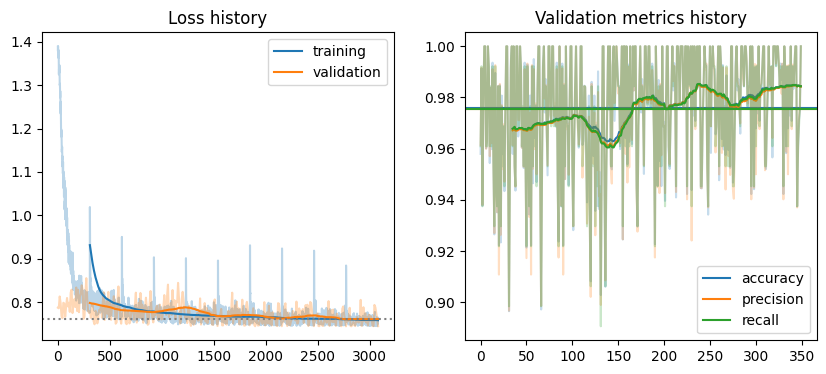

orientation-detector:  accuracy: 98.45%   precision: 98.43%   recall: 98.44%




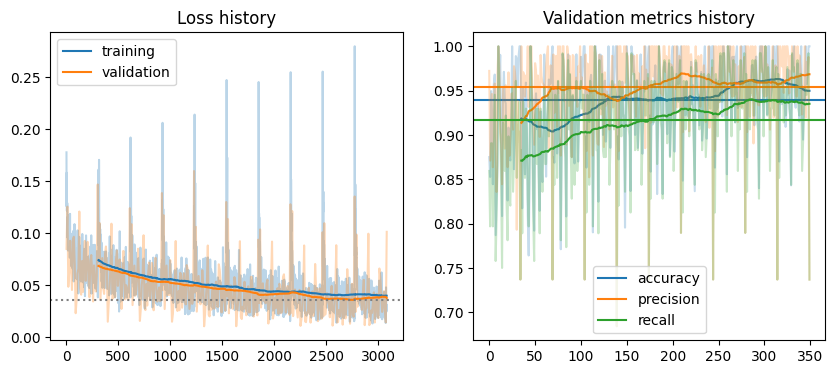

form-detector:  accuracy: 94.98%   precision: 96.84%   recall: 93.51%




In [27]:
# show the last epoch validation confusion matrix
print('Final test confusion matrix:')
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_confmat(res1['confmat'], [0, 90, 180, 270], ax[0])
ax[0].set_title('Orientation-detector')
plot_confmat(res2['confmat'], ['no-form','form'], ax[1])
ax[1].set_title('Form-detector')
plt.show()

# plot loss and validation history and print last test results
plot_history(loss_history['orientation-detector'], validation_history['orientation-detector'])
print('orientation-detector: ', end=' ')
print('   '.join([f'{m}: {np.mean(v):.2%}' for m, v in res1.items() if m != 'confmat']) + '\n\n')

plot_history(loss_history['form-detector'], validation_history['form-detector'])
print('form-detector: ', end=' ')
print('   '.join([f'{m}: {np.mean(v):.2%}' for m, v in res2.items() if m != 'confmat']) + '\n\n')

<a name="eval"></a>

### Evaluation: run inference with new data variation

In [30]:
preprocessing = transforms.Compose([
    CenterCrop(VIEW_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

def run_form_detection(image):
    # prepare the input
    size = tuple((np.array(image.shape) * VIEW_SIZE/min(image.shape)).astype(int))[::-1]
    input_image = cv2.bitwise_not(cv2.resize(image, size, interpolation=cv2.INTER_AREA))
    X = preprocessing(input_image).unsqueeze(1).to(device)
    # use our model
    form_detector.eval()
    with torch.no_grad():
        output = form_detector(X)
        return torch.round(output).cpu().item()


In [54]:
def run_orientation_detection(image):
    # prepare the input
    size = tuple((np.array(image.shape) * VIEW_SIZE/min(image.shape)).astype(int))[::-1]
    input_image = cv2.bitwise_not(cv2.resize(image, size, interpolation=cv2.INTER_AREA))
    X = preprocessing(input_image).unsqueeze(1).to(device)
    # use our model
    orientation_detector.eval()
    with torch.no_grad():
        print(X.shape)
        output = orientation_detector(X)
        print(output.shape)
        return torch.max(output, 1)[1].cpu().item()
    

In [55]:
def correct_skew(image):
    angle = detect_skew(image, max_angle=45)
    exception = 1 if abs(angle) > 10 else 0
    bg = get_bg_value(image)
    straight = img_rotate(image, angle, fill=bg)
    return fit_straight(straight), exception
    

In [56]:
def test_correction_pipeline(image):
    # correct skew and distortion
    straight, exception = correct_skew(image)
    # detect orientation
    index = run_orientation_detection(straight)
    # correct orientation
    angle = [0, 90, 180, 270][index]
    if index == 0:
        return straight, 0, exception
    bg = get_bg_value(image)
    return img_rotate(straight, -angle, fill=bg), angle, exception


In [57]:
def test_classification_pipeline(image):
    # correct skew and distortion
    straight, exception = correct_skew(image)
    # detect if the page is form-input
    return run_form_detection(straight), exception


In [58]:
num_samples = 1000

In [ ]:
results, exceptions = [], 0
for _ in range(num_samples):
    # take random page view
    source = np.random.choice(samples).split('/').pop()[:-4]
    # generate a noisy view of a filled-in form along with data for the labels
    orig, info, _ = generate_sample(source, dpi=200, light=0.3, noise=0.3)
    output, orient, exception = test_correction_pipeline(orig)
    results.append([orient, info['orient']])
    exceptions += exception

# show resulting confusion matrix
results = pd.DataFrame(np.array(results).reshape((num_samples, 2)), columns=['detected','actual'])
heatmap = results.groupby(['detected','actual']).size()
heatmap /= heatmap.sum()
classes = [0, 90, 180, 270]
if len(heatmap) < 16:
    heatmap = heatmap.reindex([(a,b) for a in classes for b in classes], fill_value=0)
print(f'skew detection failure: {exceptions/len(results):.2%}')
fig, ax = plt.subplots(figsize=(3, 3))
plot_confmat(heatmap.values.reshape((4, 4)), classes, ax)
plt.axis('off')
plt.title(f"Accuracy: {np.sum(results['detected']==results['actual'])/len(results):.2%}")
plt.show()

In [ ]:
results, exceptions = [], 0
for _ in range(num_samples):
    # take random page view with widgets info available
    source = np.random.choice([x for x in samples if not x.startswith('data/images/que-')]).split('/').pop()[:-4]
    # generate a noisy view of a filled-in form along with data for the labels
    orig, _, inputs = sim.generate_sample(source, dpi=200, light=0.3, noise=0.3)
    cls, exception = test_classification_pipeline(orig)
    results.append([cls, len(inputs) > 0])
    exceptions += exception

# show resulting confusion matrix
results = pd.DataFrame(np.array(results).reshape((num_samples, 2)), columns=['detected','actual'])
heatmap = results.groupby(['detected','actual']).size()
heatmap /= heatmap.sum()
if len(heatmap) < 4:
    heatmap = heatmap.reindex([(a,b) for a in [0,1] for b in [0,1]], fill_value=0)
print(f'skew detection failure: {exceptions/len(results):.2%}')
fig, ax = plt.subplots(figsize=(2, 2))
plot_confmat(heatmap.values.reshape((2, 2)), ['no-form','form'], ax)
plt.axis('off')
plt.title(f"Accuracy: {np.sum(results['detected']==results['actual'])/len(results):.2%}")
plt.show()

In [ ]:
# false-negative (misclassified majority class in our case)
fn = len(results[(results['actual']==1)&(results['detected']==0)])/len(results)
fp = len(results[(results['actual']==0)&(results['detected']==1)])/len(results)
print(f'misclassified majority class: {fn:.2%}  misclassified minority class: {fp:.2%}')

In [ ]:
# save models
#torch.save(encoder.state_dict(), f'./models/visual-encoder-{MODEL}.pt')
#torch.save(orientation_detector.state_dict(), f'./models/orientation-detection-baseline-{MODEL}.pt')
#torch.save(form_detector.state_dict(), f'./models/form-detection-baseline-{MODEL}.pt')